# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Luis Adrian Bravo Ramirez

**Professor**: Pablo Camarillo Ramirez

# Introduction

## Large-Scale Problem: Twitch Gamers Streaming Network Analysis

The Twitch streaming platform generates massive amounts of relational data as millions of content creators interact through follows, collaborations, raids, and viewer sharing. Analyzing this network is essential for identifying influential streamers, detecting communities, understanding content trends, and monitoring platform health. However, the scale and complexity of these relationships make it challenging to process and query efficiently using traditional relational databases. A specialized data pipeline is needed to collect, store, and analyze this graph-structured data, allowing the discover of patterns, predict trends, and make decisions regarding the found insights

## Data Sample
The Twitch Gamer network consists of two primary components
*Streamer Nodes* - Individual Twitch accounts with properties.
```bash
numeric_id: 0
views: 7879
mature: 1 (contains mature content)
life_time: 969 (days active)
created_at: 2016-02-16
updated_at: 2018-10-12
dead_account: 0 (not dead = active)
language: EN
affiliate: 1 (Twitch affiliate)
```

*Connection Edges* - Relationships between streamers.
```bash
numeric_id_1: 98343 (source streamer)
numeric_id_2: 141493 (target streamer)
```

 More detail regarding the Twitch Gamers network can be seen on Dataset section.
 
---

# Dataset

## Data Model: Graph Data Model (Neo4j)

This pipeline uses a **Graph Data Model** implemented in **Neo4j**, which is ideal for representing and querying relationships between entities. The dataset consists of nodes and relationships that form a social network graph, specifically for twitch gamers network. 

### Why Neo4j?

The Neo4j property graph model is ideal for this dataset because:
1. **Cypher Query Language:** Intuitive pattern-matching syntax for complex relationship queries
2. **Index Support:** Automatic indexing on node IDs and custom indexes for properties
3. **Network Analysis:** Built-in algorithms for Network Analysis (Community, Pathfinding and more).
4. **Scalability:** Handles millions of nodes and relationships
5. **Visualization:** Neo4j Browser provides interactive graph visualization
6. **Knowledge**: I've worked with Neo4j for a long time, so I'm well experienced with this NoSQL database.

## Node Schema

Nodes represent individual accounts/users in the network with the following properties:

| Property | Data Type | Description |
|----------|-----------|-------------|
| `numeric_id` | Integer | Unique identifier for the node |
| `views` | Integer | Number of views on the account |
| `mature` | Boolean | Indicates if account contains mature content (0 for NO, 1 for YES) |
| `life_time` | Integer | Account lifetime in days |
| `created_at` | Date | Account creation date (YYYY-MM-DD format) |
| `updated_at` | Date | Last update date (YYYY-MM-DD format) |
| `dead_account` | Boolean | Indicates if account is inactive (0 for NO, 1 for YES) |
| `language` | String | Account language (English, Deutsch, Other) |
| `affiliate` | Boolean | Indicates if account is affiliated (0 for NO, 1 for YES) |

### Example Node
```cypher
(:Account {
  numeric_id: 0,
  views: 7879,
  mature: true,
  life_time: 969,
  created_at: date('2016-02-16'),
  updated_at: date('2018-10-12'),
  dead_account: false,
  language: 'English',
  affiliate: true
})
```

## Relationship Schema

Relationships represent connections between nodes in the network.

| Property | Data Type | Description |
|----------|-----------|-------------|
| `numeric_id_1` | Integer | Source node ID |
| `numeric_id_2` | Integer | Target node ID |

### Relationship Type
- **Type:** `FOLLOWS` 
- **Direction:** Directed (from numeric_id_1 to numeric_id_2)
- **Properties:** None


## Dataset Source
**Source:** Kaggle Public Repository
**Dataset URL:** [https://www.kaggle.com/datasets/wolfram77/graphs-social]

**Data Format:**
- **Nodes File:** CSV format with 9 columns
- **Edges File:** CSV format with 2 columns

---

# Transformations and Actions

Here, the transformations (create new columns, aggreate, run joins, etc.) will take place. For this case, we'll execute the following:

1. Remove duplicates using `numeric_id` entries and clean null values (if they exist).

2. Convert `mature`, `dead_account`and `affiliate` from interger (0 or 1) to a boolean type (true or false).

3. Parse `created_at`and `updated_at` string into date objects.

4. Make sure that `numeric_id`, `views`, and `life_time` are integers.

5. Add a column called `activity_status` that will categorize the account activity with these values:
    - "Very Active" (updated within 30 days)
    - "Active" (within 90 days)
    - "Less Active" (within 180 days)
    - "Inactive" (no activity)

6. Add a column called `account_category` that will classify the account based on views:
    - "Nano": views < 1,000 (New or very small streamers)
    - "Micro": 1,000 ≤ views < 10,000 (Small but growing audience)
    - "Mid-Tier": 10,000 ≤ views < 50,000 (Established presence)
    - "Macro": 50,000 ≤ views < 100,000 (Significant reach)
    - "Mega": 100,000 ≤ views < 500,000 (High influence)
    - "Elite": views ≥ 500,000 (Top-tier streamers)

7. Trim whitespace from all string fields to avoid any future issues with these fields.


In [1]:
# Find the PySpark Installation
import findspark
findspark.init()

In [2]:
# Create Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.neo4j#neo4j-connector-apache-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f229455f-ea7a-4932-9f4f-33683049a4e8;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.13;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.13_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in central
	found org.neo4j#caniuse-api;1.3.0 in central
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in central
	found org.jetbrains#annotations;13.0 in central
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in central
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in central
	found org.reactivestreams#reactive-streams;1.0.4 in central
	found io.netty#netty-handler;4.1.

### Define the schema

In [3]:
from luisbravor00.spark_utils import SparkUtils

twitch_nodes_schema_columns = [
    ("views", "int"),
    ("mature", "int"),
    ("life_time", "int"),
    ("created_at", "string"),
    ("updated_at", "string"),
    ("numeric_id", "int"),
    ("dead_account", "int"),
    ("language", "string"),
    ("affiliate", "int")
]

twitch_edges_schema_columns = [
    ("source_account", "int"),
    ("target_account", "int")
]

twitch_nodes_schema = SparkUtils.generate_schema(twitch_nodes_schema_columns)
twitch_edges_schema = SparkUtils.generate_schema(twitch_edges_schema_columns)

### Load CSV files (Nodes and Edges)

In [4]:
# Read and load the csv file for the nodes
df_nodes = spark.read \
                .option("header", "true") \
                .schema(twitch_nodes_schema) \
                .csv("/opt/spark/work-dir/data/twitch_gamers/large_twitch_features.csv")

In [5]:
# Read and load the csv file for the edges
df_edges = spark.read \
                .option("header", "true") \
                .schema(twitch_edges_schema) \
                .csv("/opt/spark/work-dir/data/twitch_gamers/large_twitch_edges.csv")

### Start with transformations

In [6]:
from pyspark.sql.functions import col, trim, when, isnull, count, to_date, max, datediff, lit, desc

In [7]:
# Remove duplicates using numeric_id and clean null values

print(f"Number of records for df_nodes before cleaning: {df_nodes.count()}")
df_nodes.select([count(when(isnull(c[0]) | col(c[0]).isNull(), c[0])).alias(c[0]) for c in twitch_nodes_schema_columns]).show()

# Perform data cleaning with trim (column by column)
df_nodes_clean = df_nodes \
        .dropDuplicates(["numeric_id"]) \
        .filter(col("numeric_id").isNotNull()) \
        .filter(col("views").isNotNull()) \
        .filter(col("mature").isNotNull()) \
        .filter(col("life_time").isNotNull()) \
        .filter(col("dead_account").isNotNull()) \
        .filter(col("affiliate").isNotNull()) \
        .withColumn("created_at", trim("created_at")) \
        .withColumn("updated_at", trim("updated_at")) \
        .withColumn("language", trim("language")) \

# Perform data cleaning with dropna (make sure that it erases null values)
df_nodes_clean = df_nodes_clean.dropna()
print(f"\nNumber of records for df_nodes after cleaning with trim & dropna: {df_nodes_clean.count()}\n")

Number of records for df_nodes before cleaning: 168114
+-----+------+---------+----------+----------+----------+------------+--------+---------+
|views|mature|life_time|created_at|updated_at|numeric_id|dead_account|language|affiliate|
+-----+------+---------+----------+----------+----------+------------+--------+---------+
|    0|     0|        0|         0|         0|         0|           0|       0|        0|
+-----+------+---------+----------+----------+----------+------------+--------+---------+




Number of records for df_nodes after cleaning with trim & dropna: 168114



In [8]:
# Remove duplicates using numeric_id and clean null values

print(f"Number of records for df_edges before cleaning: {df_edges.count()}")
df_edges.select([count(when(isnull(c[0]) | col(c[0]).isNull(), c[0])).alias(c[0]) for c in twitch_edges_schema_columns]).show()

# Perform data cleaning with trim (column by column)
df_edges_clean = df_edges \
        .dropDuplicates(["source_account", "target_account"]) \
        .filter(col("source_account").isNotNull()) \
        .filter(col("target_account").isNotNull()) \
        .withColumn("source_account", trim(col("source_account").cast("string"))) \
        .withColumn("target_account", trim(col("target_account").cast("string"))) \
        .dropna()

# Perform data cleaning with dropna (make sure that it erases null values)
df_edges_clean = df_edges_clean.dropna()
print(f"\nNumber of records for df_edges after cleaning with trim & dropna: {df_edges_clean.count()}\n")

Number of records for df_edges before cleaning: 6797557


+--------------+--------------+
|source_account|target_account|
+--------------+--------------+
|             0|             0|
+--------------+--------------+




Number of records for df_edges after cleaning with trim & dropna: 6797557



In [9]:

# Convert mature, dead_account and affiliate from integer to boolean
df_nodes_clean = df_nodes_clean \
    .withColumn("mature", col("mature").cast("boolean")) \
    .withColumn("dead_account", col("dead_account").cast("boolean")) \
    .withColumn("affiliate", col("affiliate").cast("boolean"))

In [10]:
# Parse created_at and updated_at string values into date objects
df_nodes_clean = df_nodes_clean \
    .withColumn("created_at", to_date("created_at")) \
    .withColumn("updated_at", to_date("updated_at"))

* Already checked that `numeric_id`, `views` and `life_time` fields are **integers**.

In [11]:
# Add a columns called activity status that will categorize the account activity using the updated_at field
## Get the latest date from the updated_at column so we can use it as current date
max_date = df_nodes_clean.select(max(col("updated_at")).alias("max_date")).collect()[0]["max_date"]

## Add the new column activity_status and compute it's values
df_nodes_clean = df_nodes_clean.withColumn(
    "activity_status",
    when(datediff(lit(max_date), col("updated_at")) <= 30, "Very Active")
    .when(datediff(lit(max_date), col("updated_at")) <= 90, "Active")
    .when(datediff(lit(max_date), col("updated_at")) <= 180, "Less Active")
    .otherwise("Inactive")
)

In [12]:
# Add a column called account_category that will classify the account based on views column
df_nodes_clean = df_nodes_clean.withColumn(
    "account_category",
    when(col("views") < 1000, "Starter")
    .when((col("views") >= 1000) & (col("views") < 10000), "Emerging")
    .when((col("views") >= 10000) & (col("views") < 50000), "Established")
    .when((col("views") >= 50000) & (col("views") < 100000), "Popular")
    .when((col("views") >= 100000) & (col("views") < 500000), "Star")
    .otherwise("Legend")
)

### Get only the first 100 nodes
Here, we'll get the first 100 nodes from my `df_clean_nodes` because there are a lot of nodes (168,114) on the dataset, and there are more edges (6,797,558). This would take a long time to add to the Neo4j database. I'll cut that off.

In [13]:
# Get the first 5,000 nodes
df_final_nodes = df_nodes_clean.limit(5000)

In [14]:
# Get the final edges for those 5,000 nodes
df_final_edges = df_edges \
    .join(df_final_nodes.select("numeric_id").alias("source"), col("source_account") == col("source.numeric_id")) \
    .join(df_final_nodes.select("numeric_id").alias("target"), col("target_account") == col("target.numeric_id")) \
    .select(df_edges["*"])

---

# Persistence Data

### Printing the final schema for nodes and edges


In [15]:
df_final_nodes.printSchema()
df_final_edges.printSchema()

root
 |-- views: integer (nullable = true)
 |-- mature: boolean (nullable = true)
 |-- life_time: integer (nullable = true)
 |-- created_at: date (nullable = true)
 |-- updated_at: date (nullable = true)
 |-- numeric_id: integer (nullable = true)
 |-- dead_account: boolean (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate: boolean (nullable = true)
 |-- activity_status: string (nullable = false)
 |-- account_category: string (nullable = false)

root
 |-- source_account: integer (nullable = true)
 |-- target_account: integer (nullable = true)



### Write data into Neo4j

In [16]:
# Connect to the Neo4j database
neo4j_url = "bolt://neo4j-iteso:7687"
neo4j_user = "neo4j"
neo4j_passwd = "neo4j@1234"

# Write account nodes into Neo4j
df_final_nodes.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Overwrite") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("labels", ":Account") \
  .option("node.keys", "numeric_id") \
  .save()

print(f"{df_final_nodes.count()} Account nodes written in Neo4j!")

# Write relationships into Neo4j
df_final_edges.write \
  .format("org.neo4j.spark.DataSource") \
  .mode("Append") \
  .option("url", neo4j_url) \
  .option("authentication.basic.username", neo4j_user) \
  .option("authentication.basic.password", neo4j_passwd) \
  .option("relationship", "FOLLOWS") \
  .option("relationship.save.strategy", "keys") \
  .option("relationship.source.labels", ":Account") \
  .option("relationship.source.save.mode", "match") \
  .option("relationship.source.node.keys", "source_account:numeric_id") \
  .option("relationship.target.labels", ":Account") \
  .option("relationship.target.save.mode", "match") \
  .option("relationship.target.node.keys", "target_account:numeric_id") \
  .save()

print(f"{df_final_edges.count()} (Account -> FOLLOWS -> Account) relationships written in Neo4j!")


5000 Account nodes written in Neo4j!


5355 (Account -> FOLLOWS -> Account) relationships written in Neo4j!


### General graph view


Graph Schema \
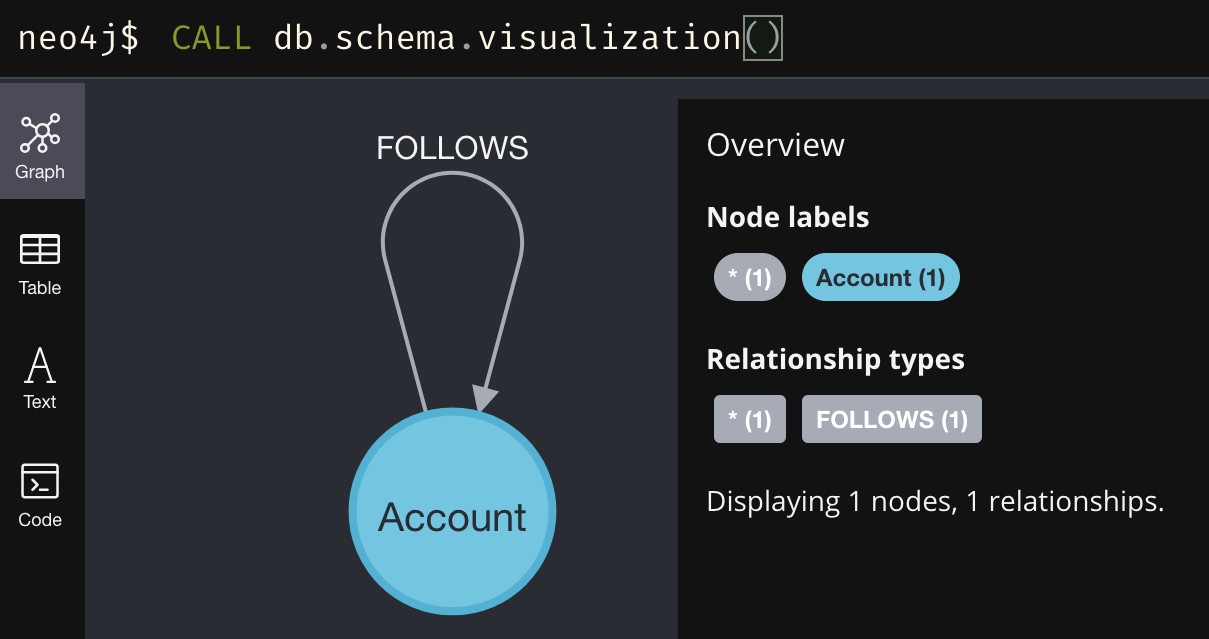

Node Attributes \
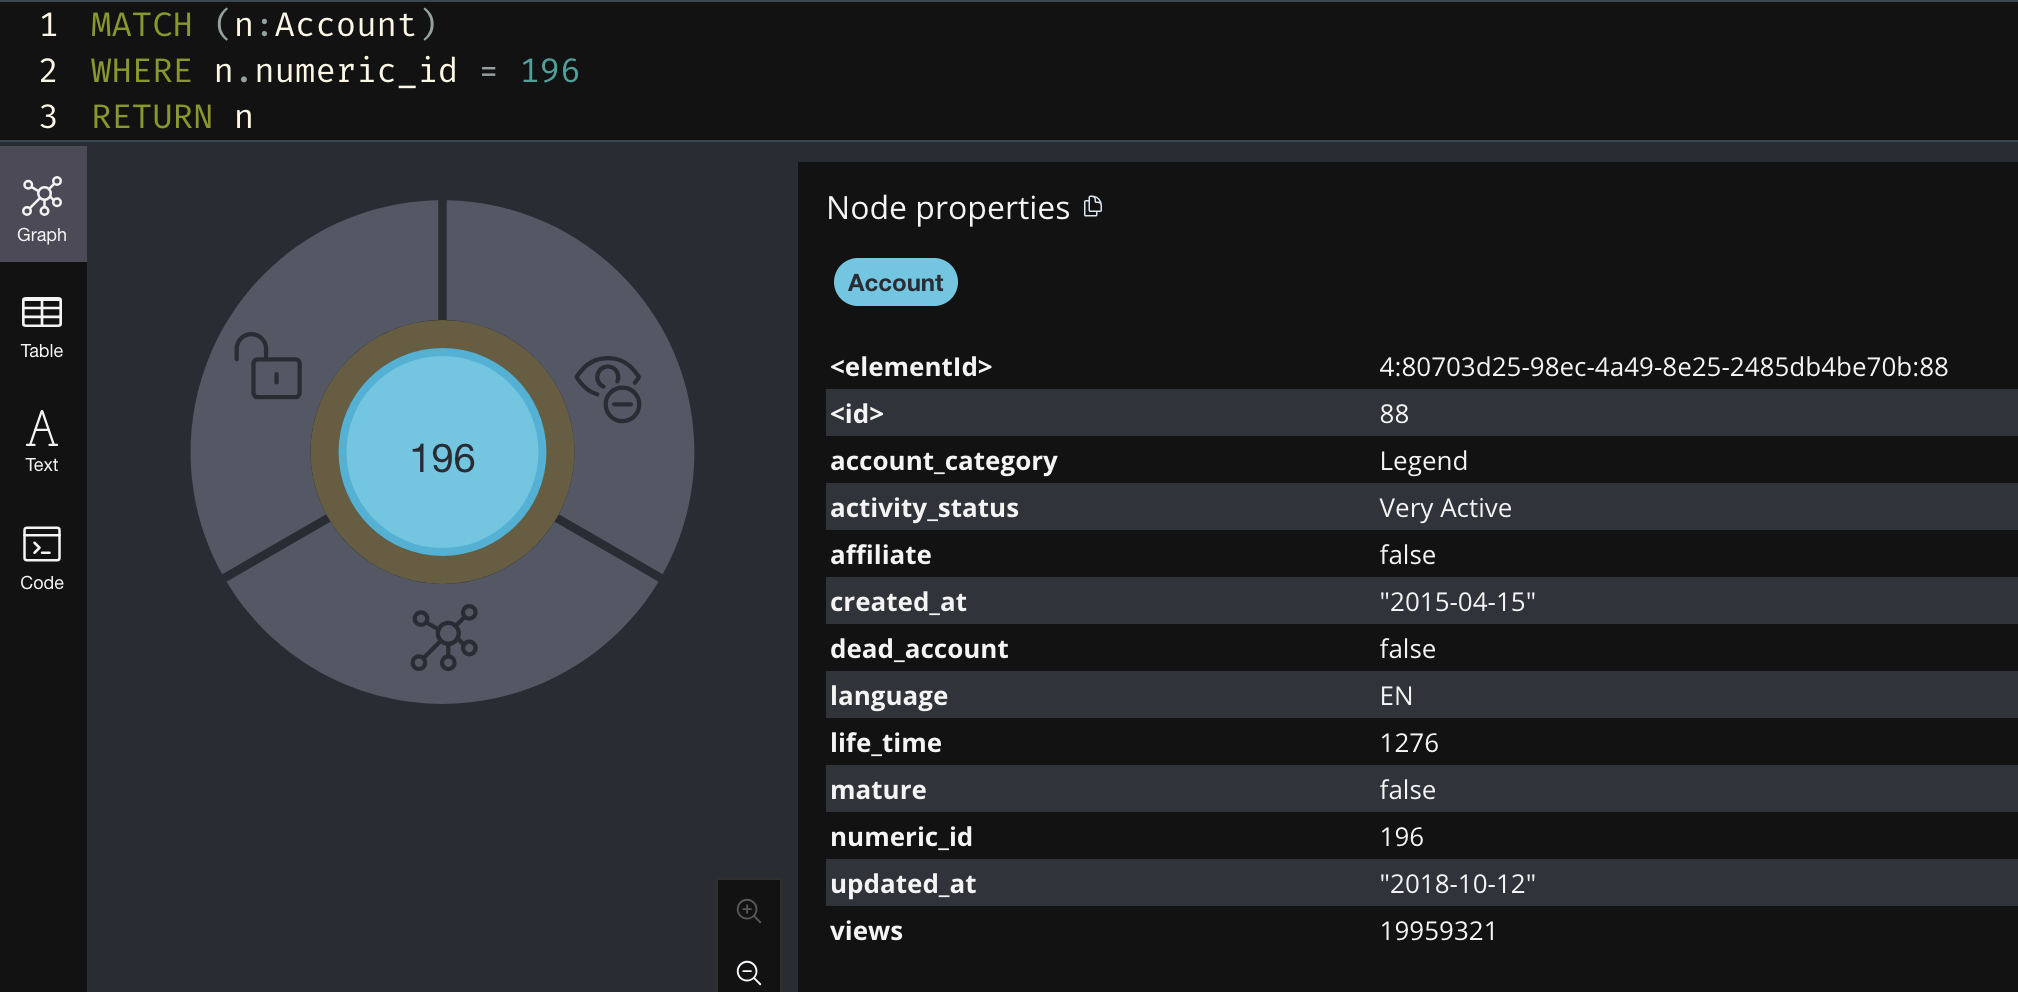

Edge Attributes \
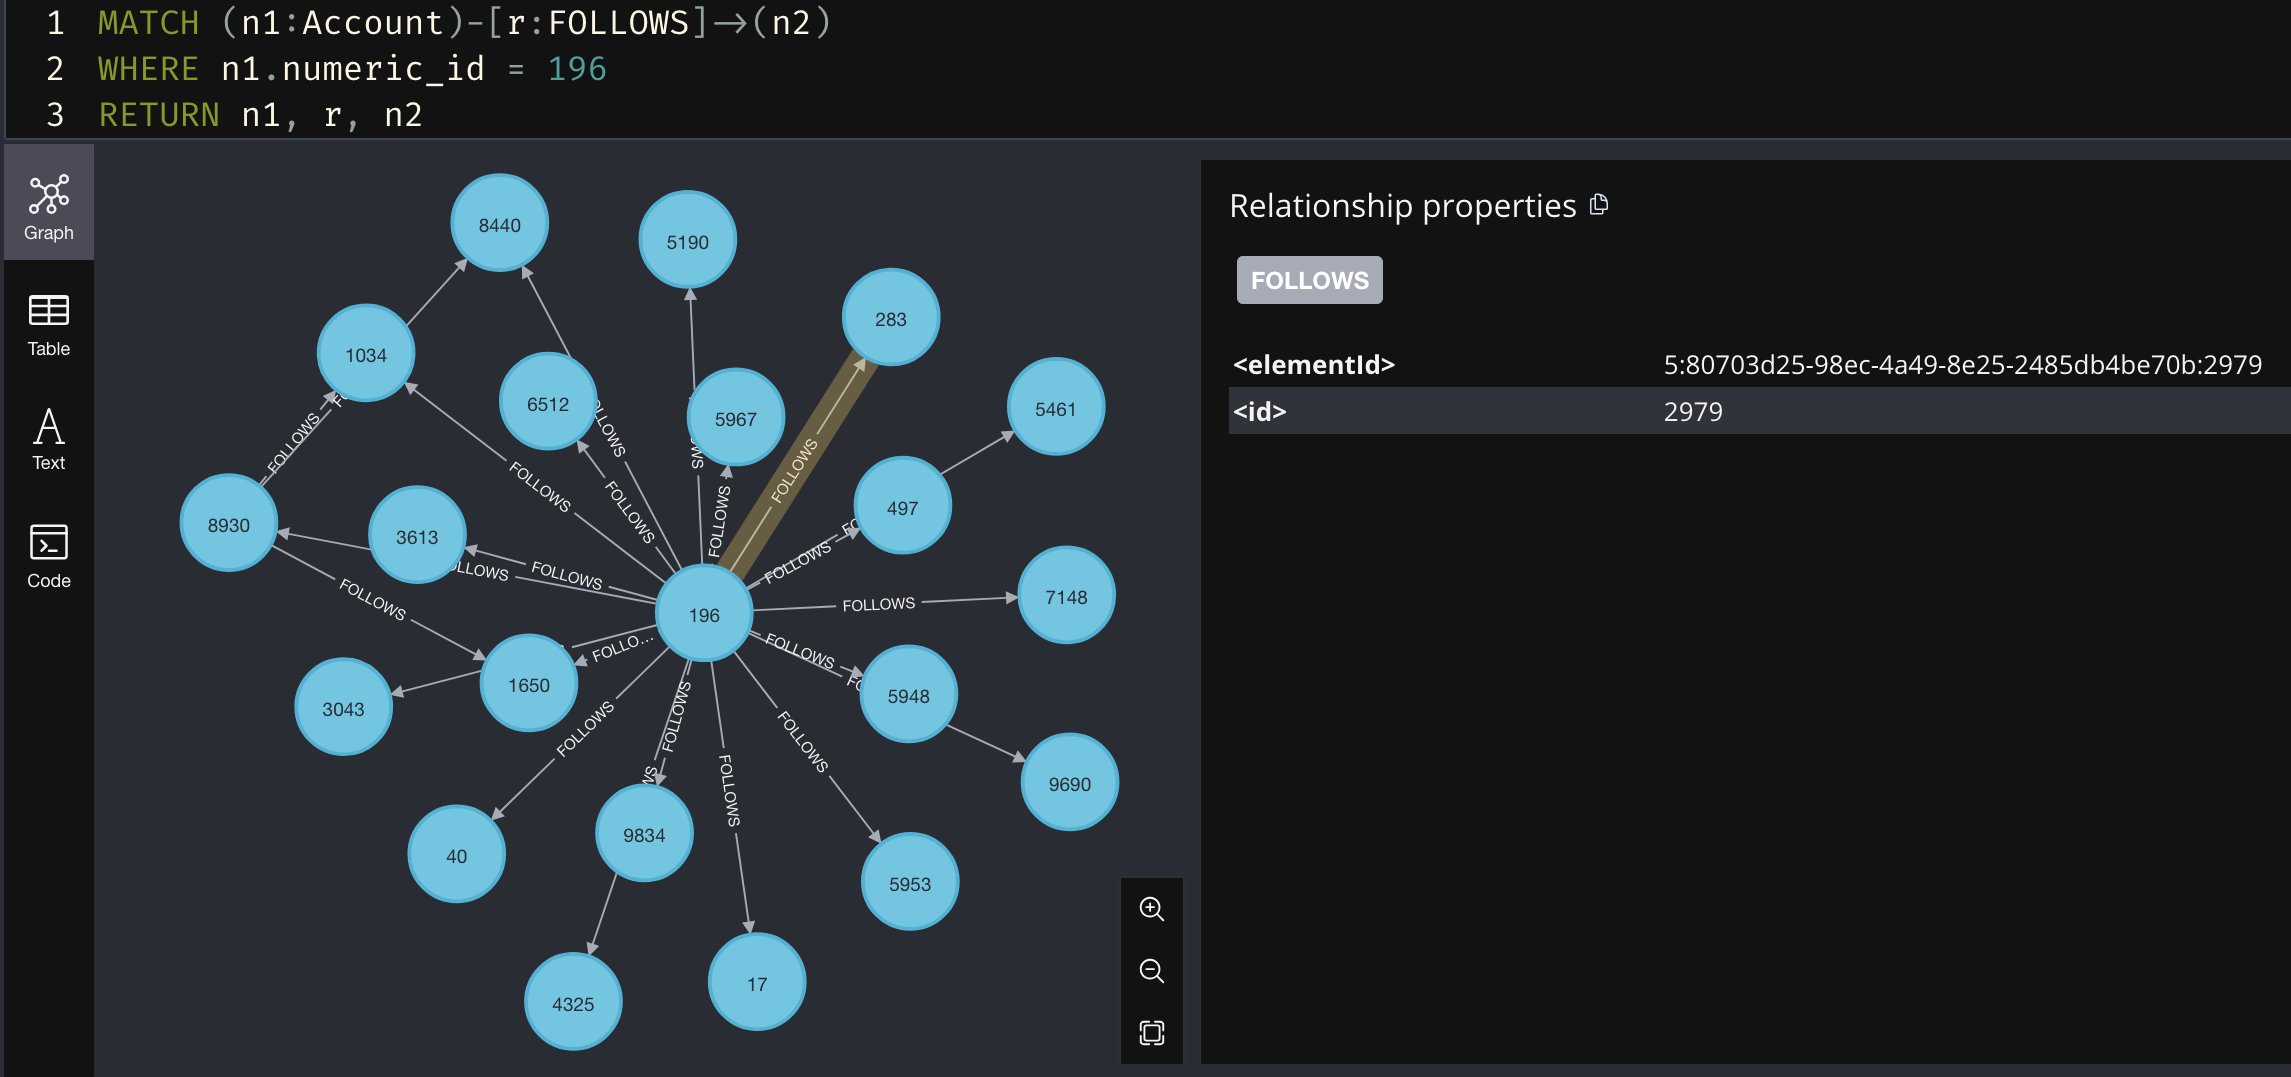

### Running a query
This query will find the top 10 most followed Accounts on the dataset and how many followers does this account has.
** Remember, we do not have all the records from the original dataset **

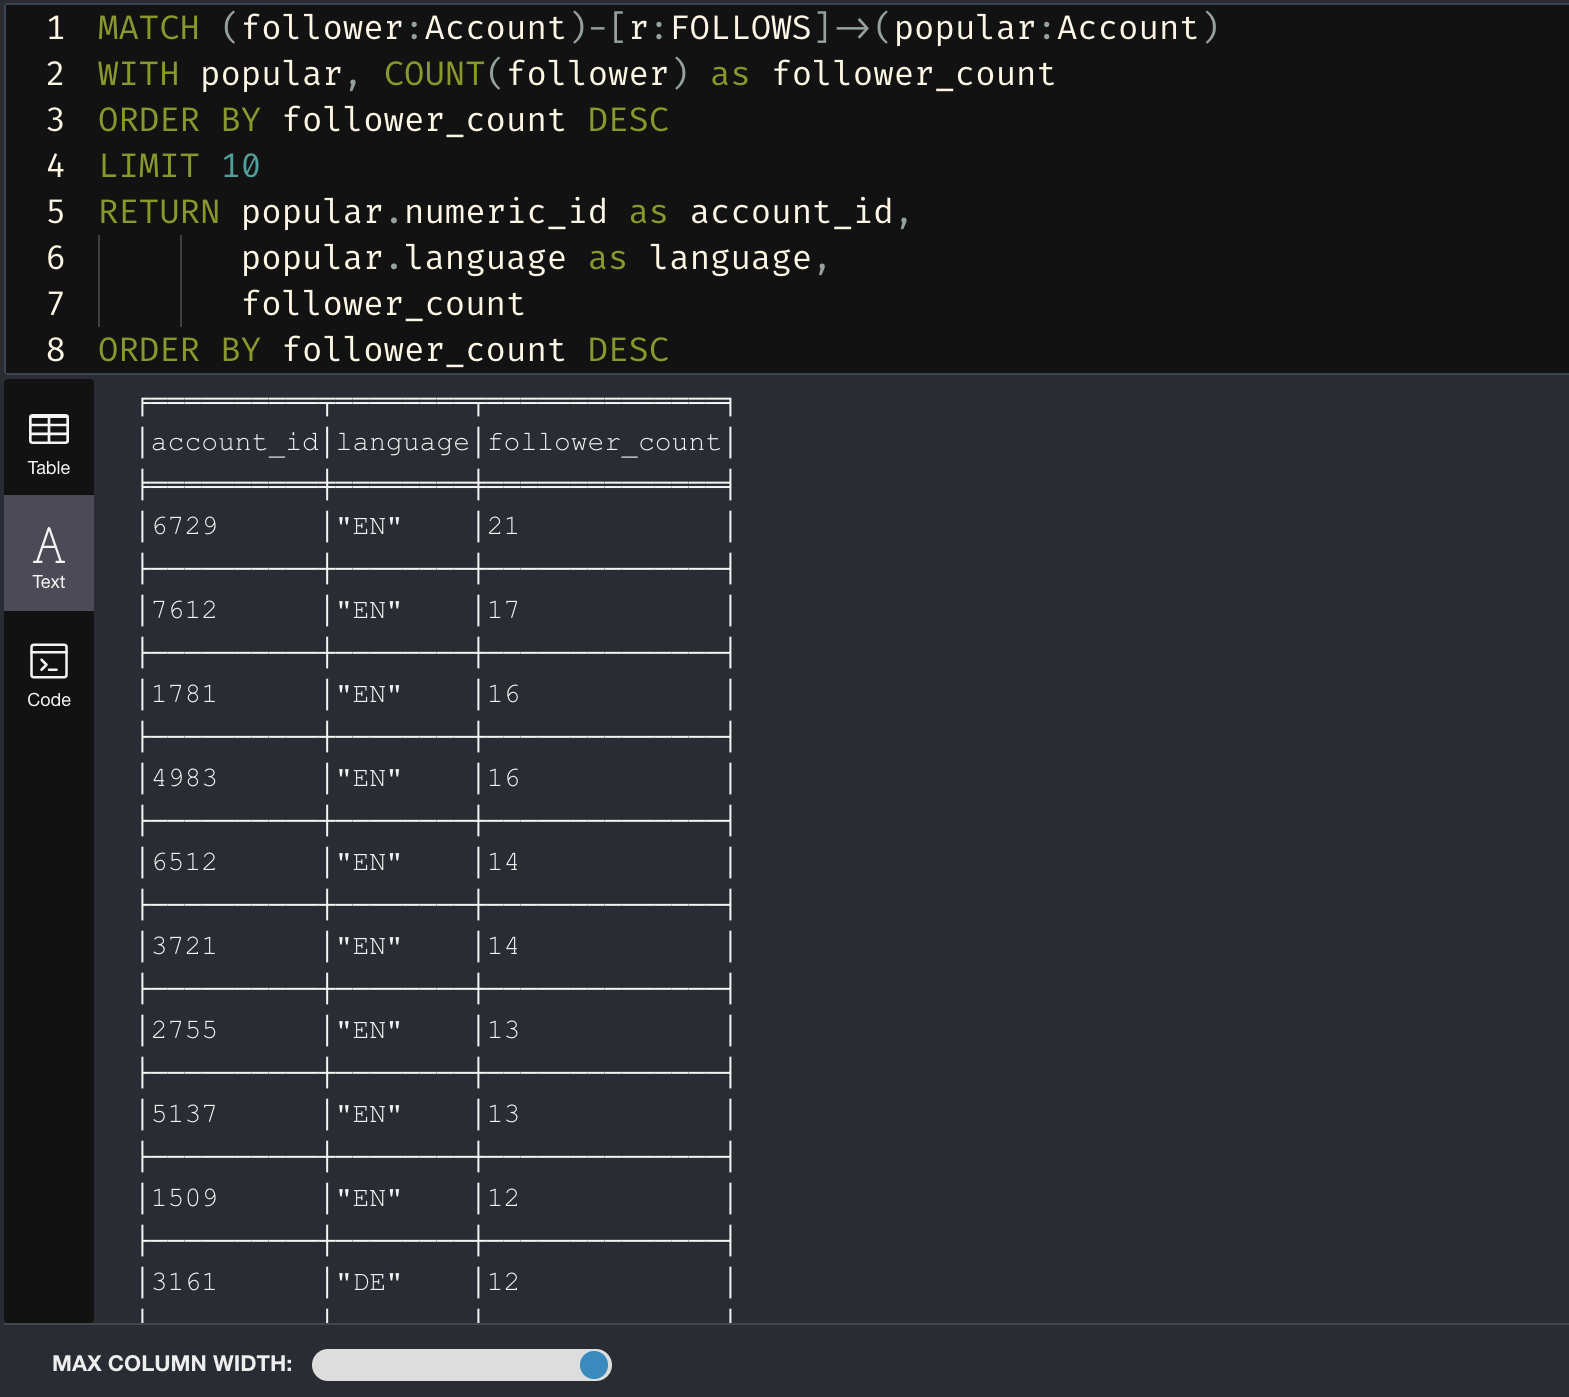

In [17]:
# Running the same query from above but using the dataframe with pyspark
from pyspark.sql.functions import col, count, desc

# Find the top 10 most followed accounts
df_most_followed = df_final_edges \
    .groupBy("target_account") \
    .agg(count("source_account").alias("follower_count")) \
    .join(df_final_nodes, col("target_account") == col("numeric_id"), "inner") \
    .select(col("numeric_id").alias("account_id"), col("language"), col("follower_count")) \
    .orderBy(desc("follower_count")) \
    .limit(10)

df_most_followed.show()

+----------+--------+--------------+
|account_id|language|follower_count|
+----------+--------+--------------+
|      6729|      EN|            21|
|      7612|      EN|            17|
|      1781|      EN|            16|
|      4983|      EN|            16|
|      3721|      EN|            14|
|      6512|      EN|            14|
|      2755|      EN|            13|
|      5137|      EN|            13|
|      1509|      EN|            12|
|      3161|      DE|            12|
+----------+--------+--------------+



---

# DAG

Here is the DAG related to the data persist stage will be shown. 

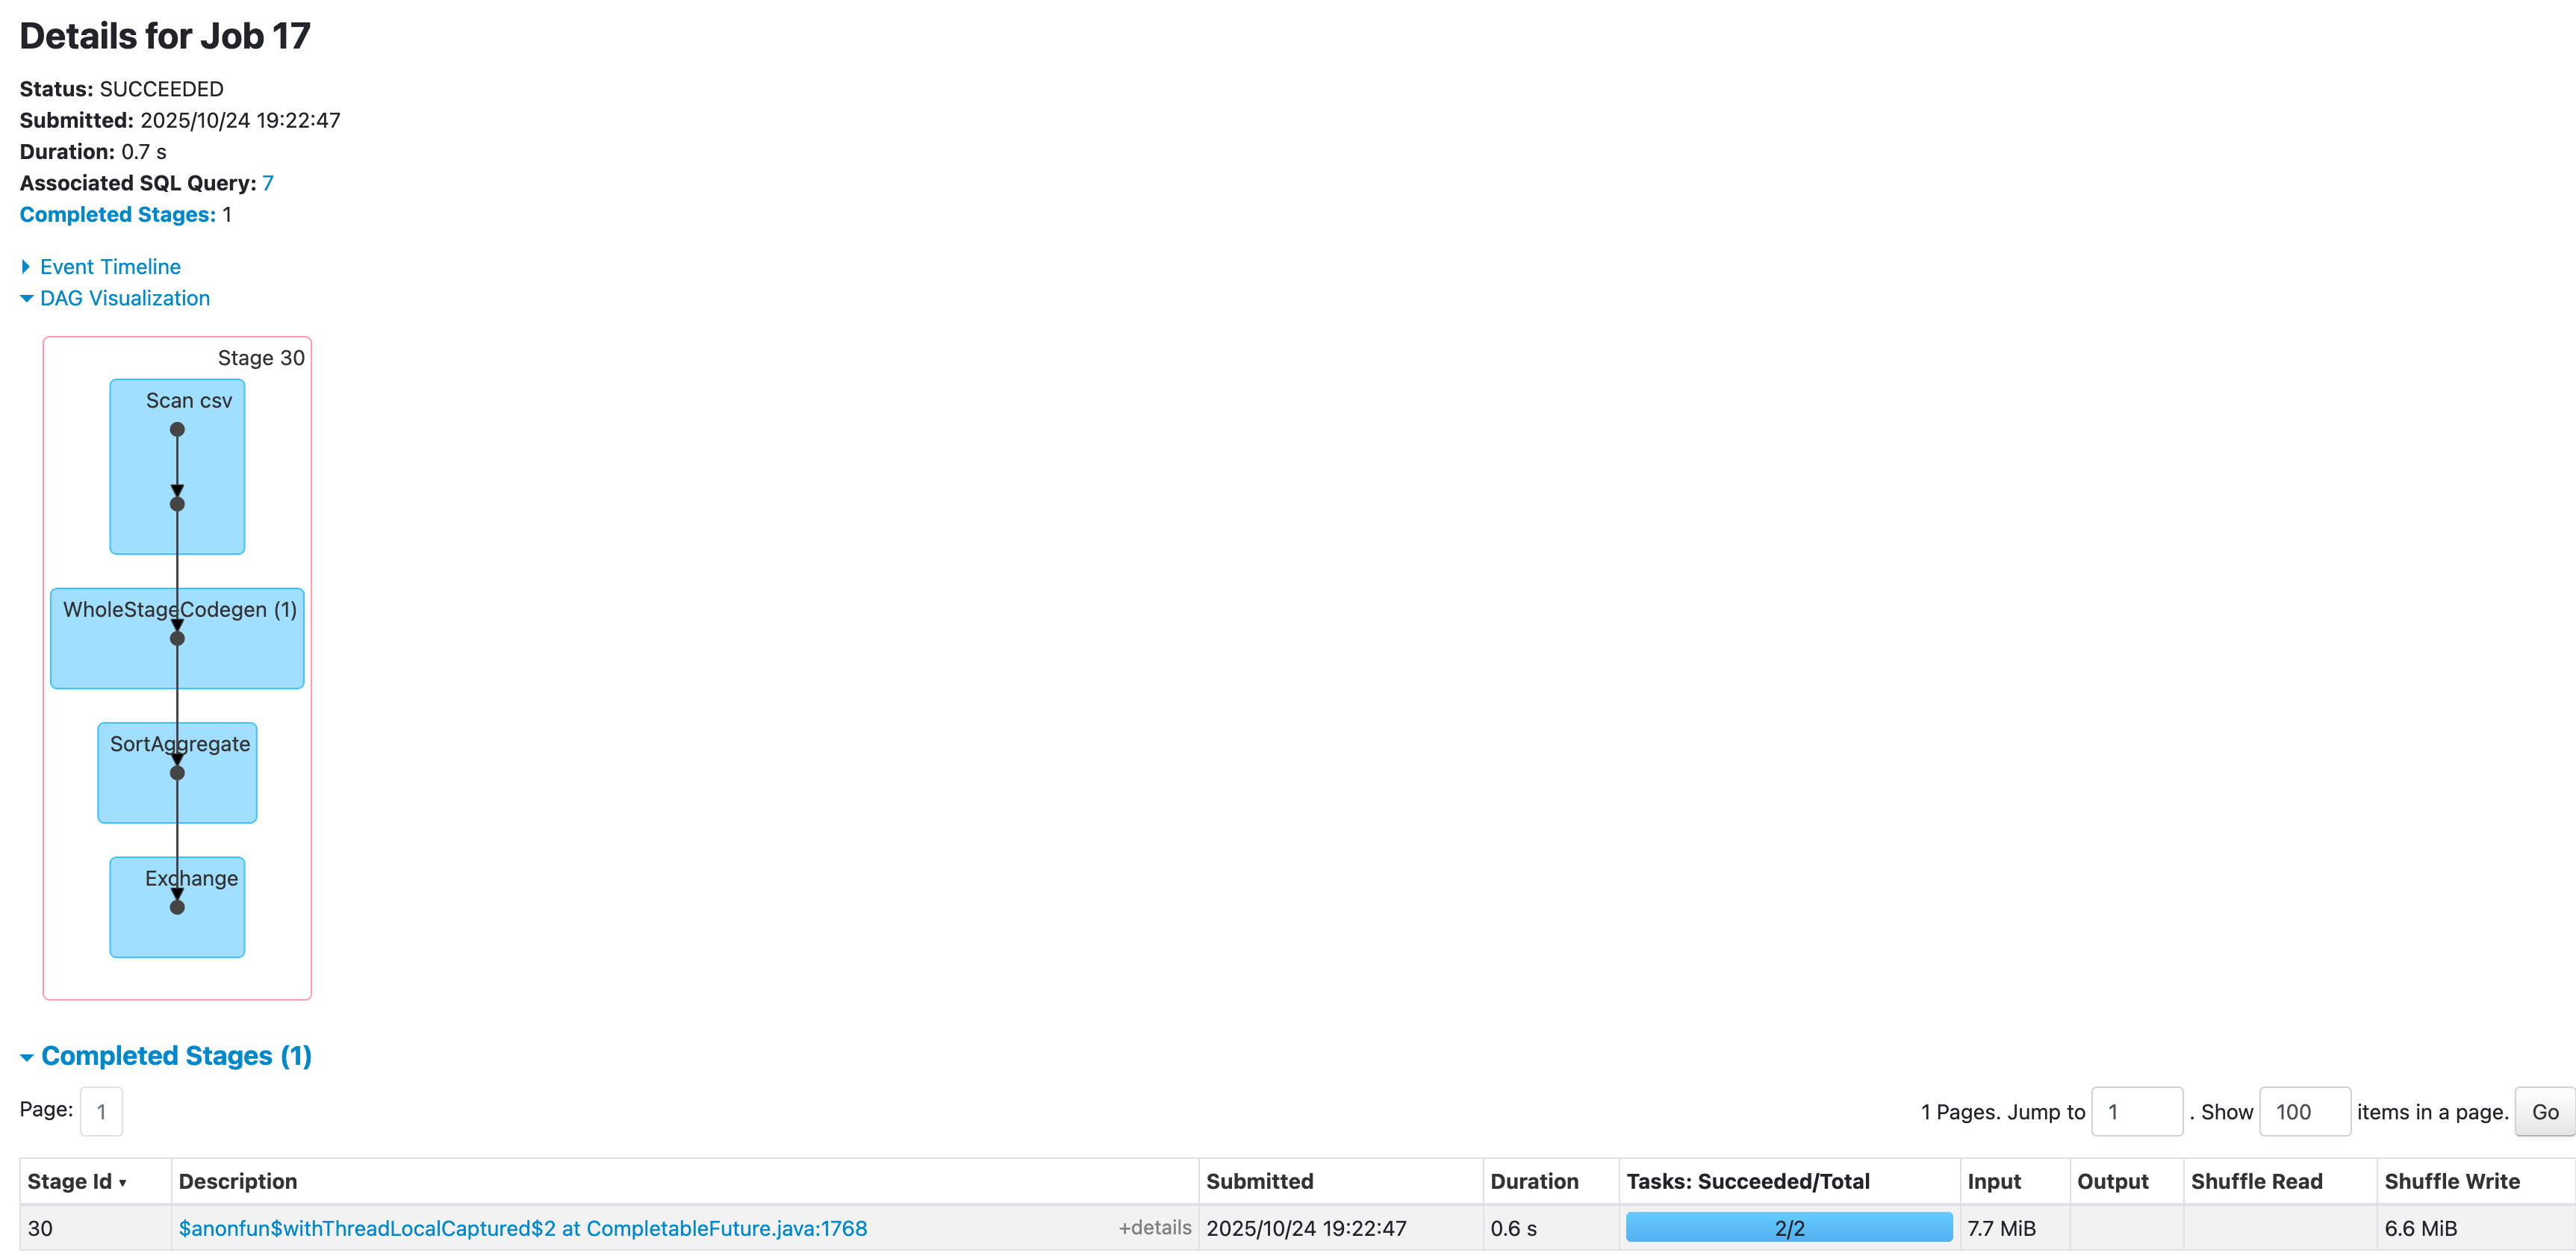

We can see the Stage 30 which is the one related to the first job executed on the persistance process. 

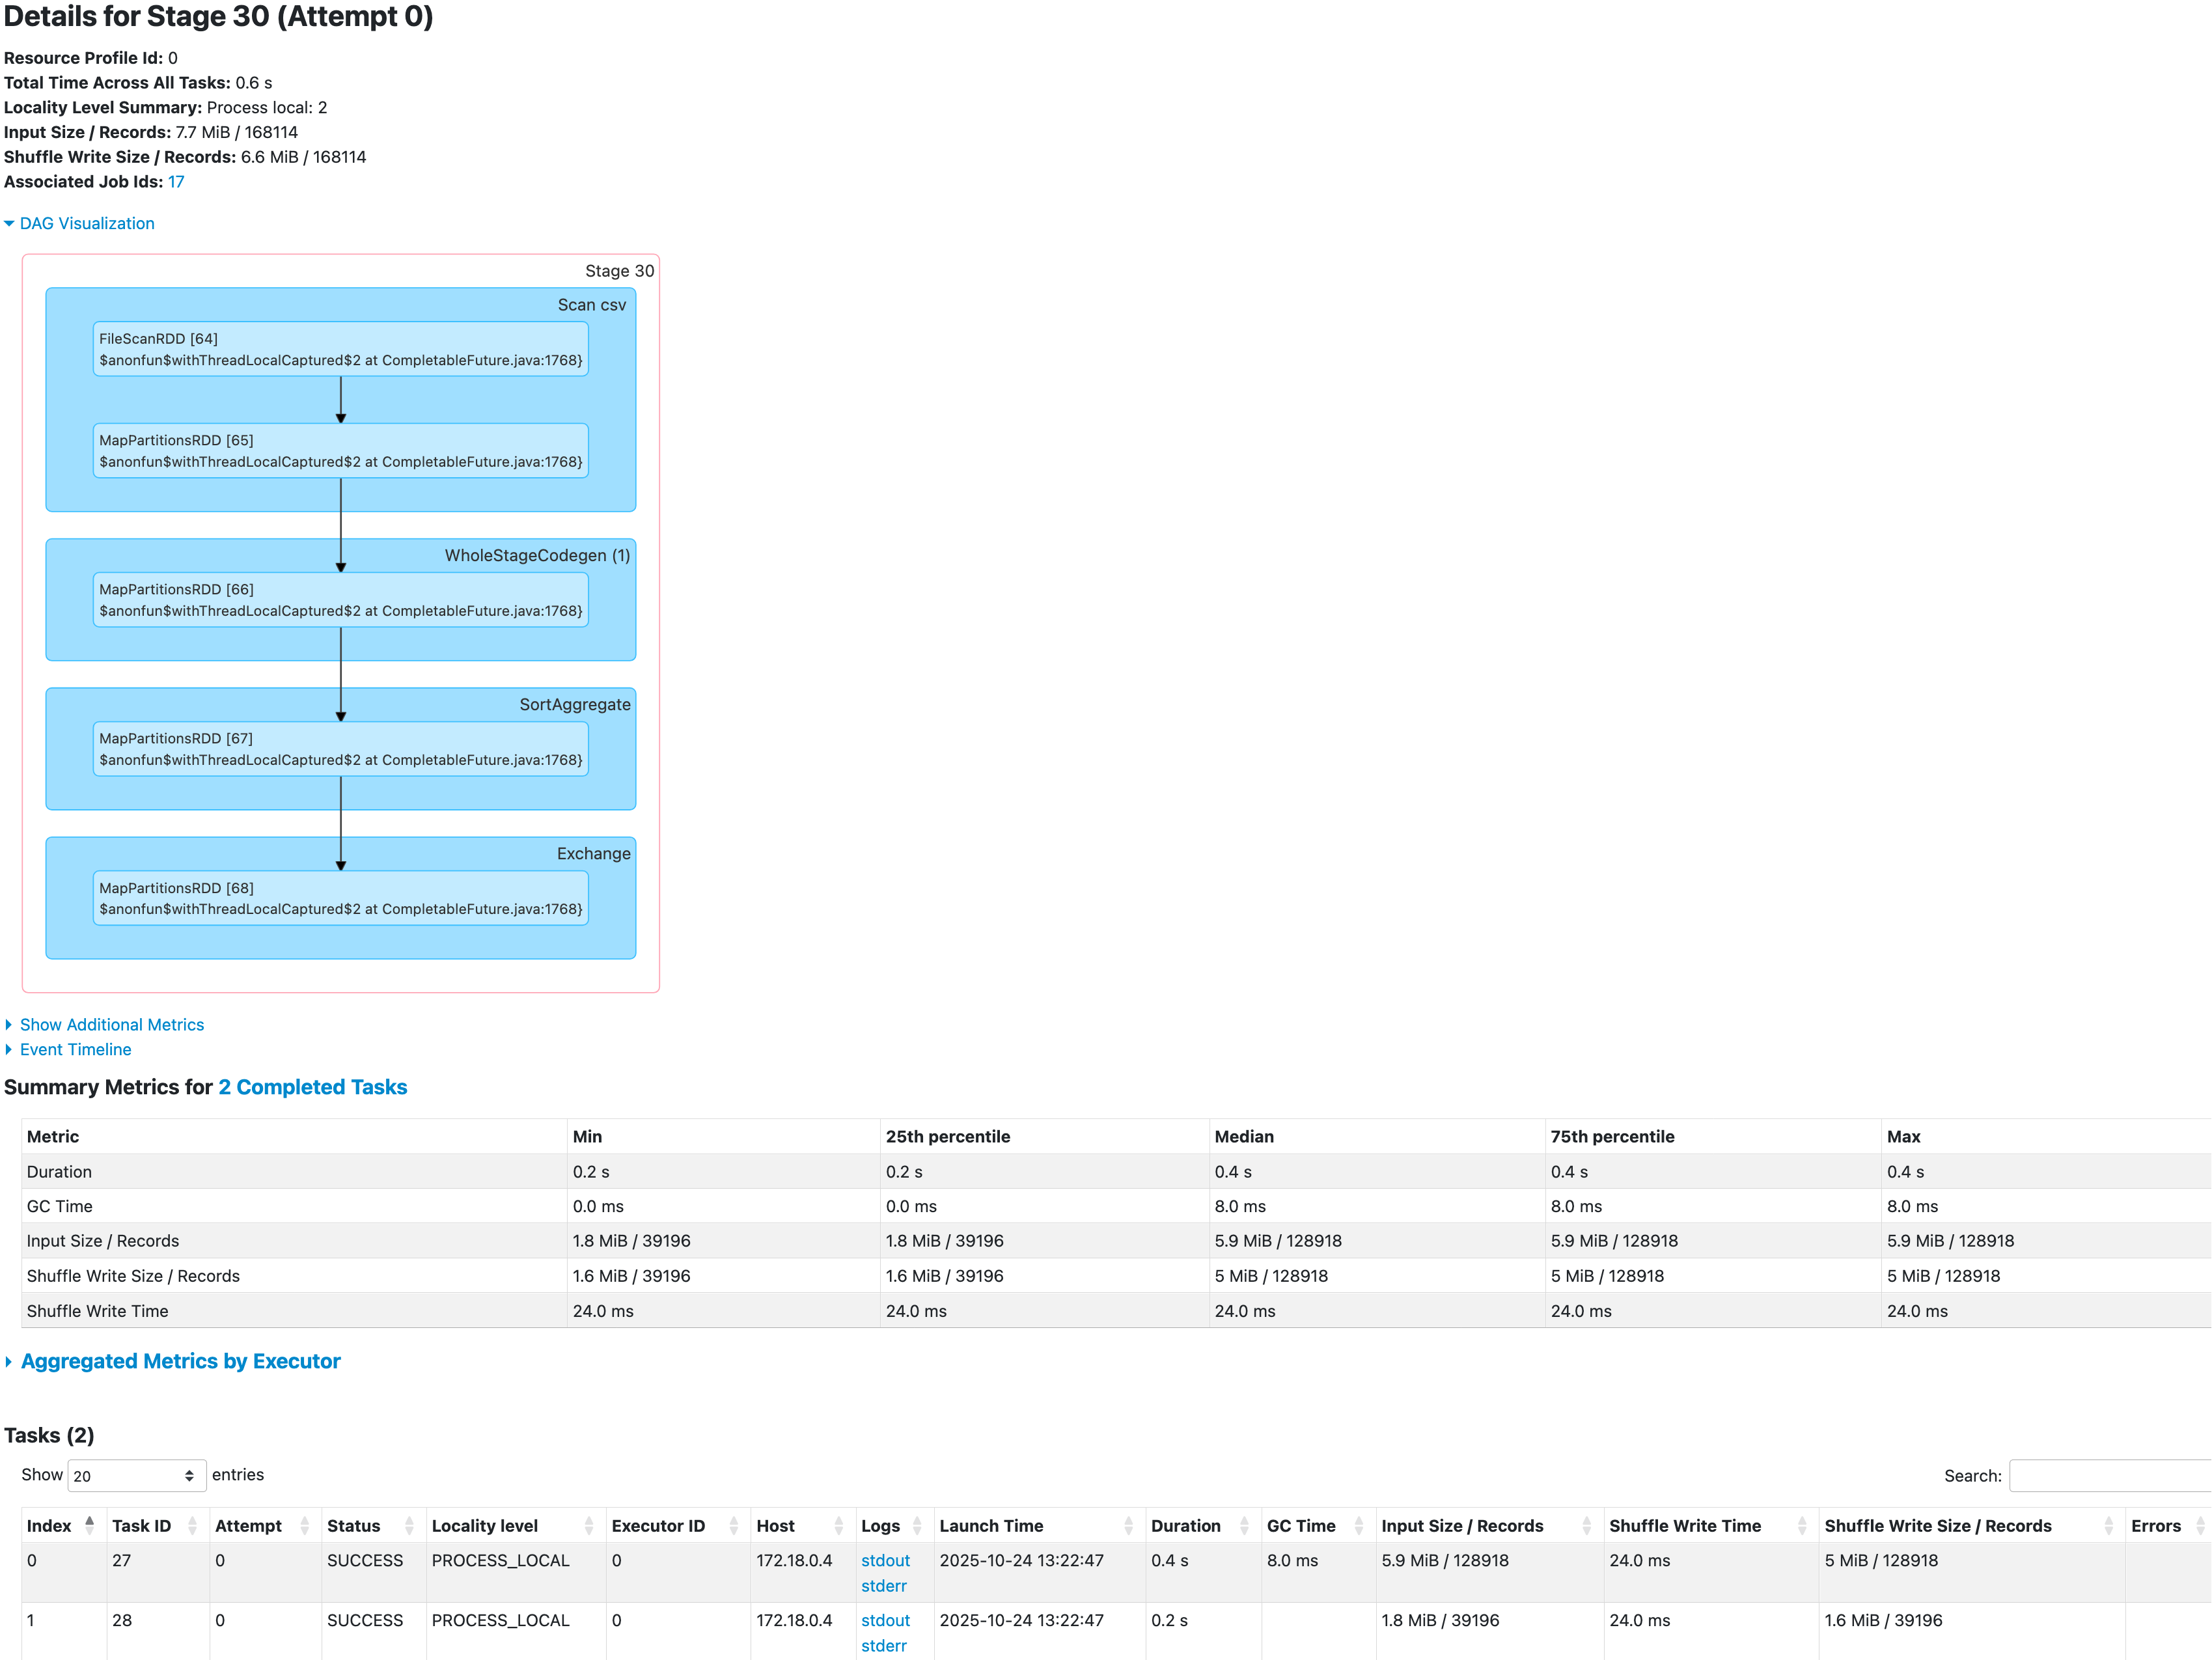

Also, we see the next Job executed and it's stages.

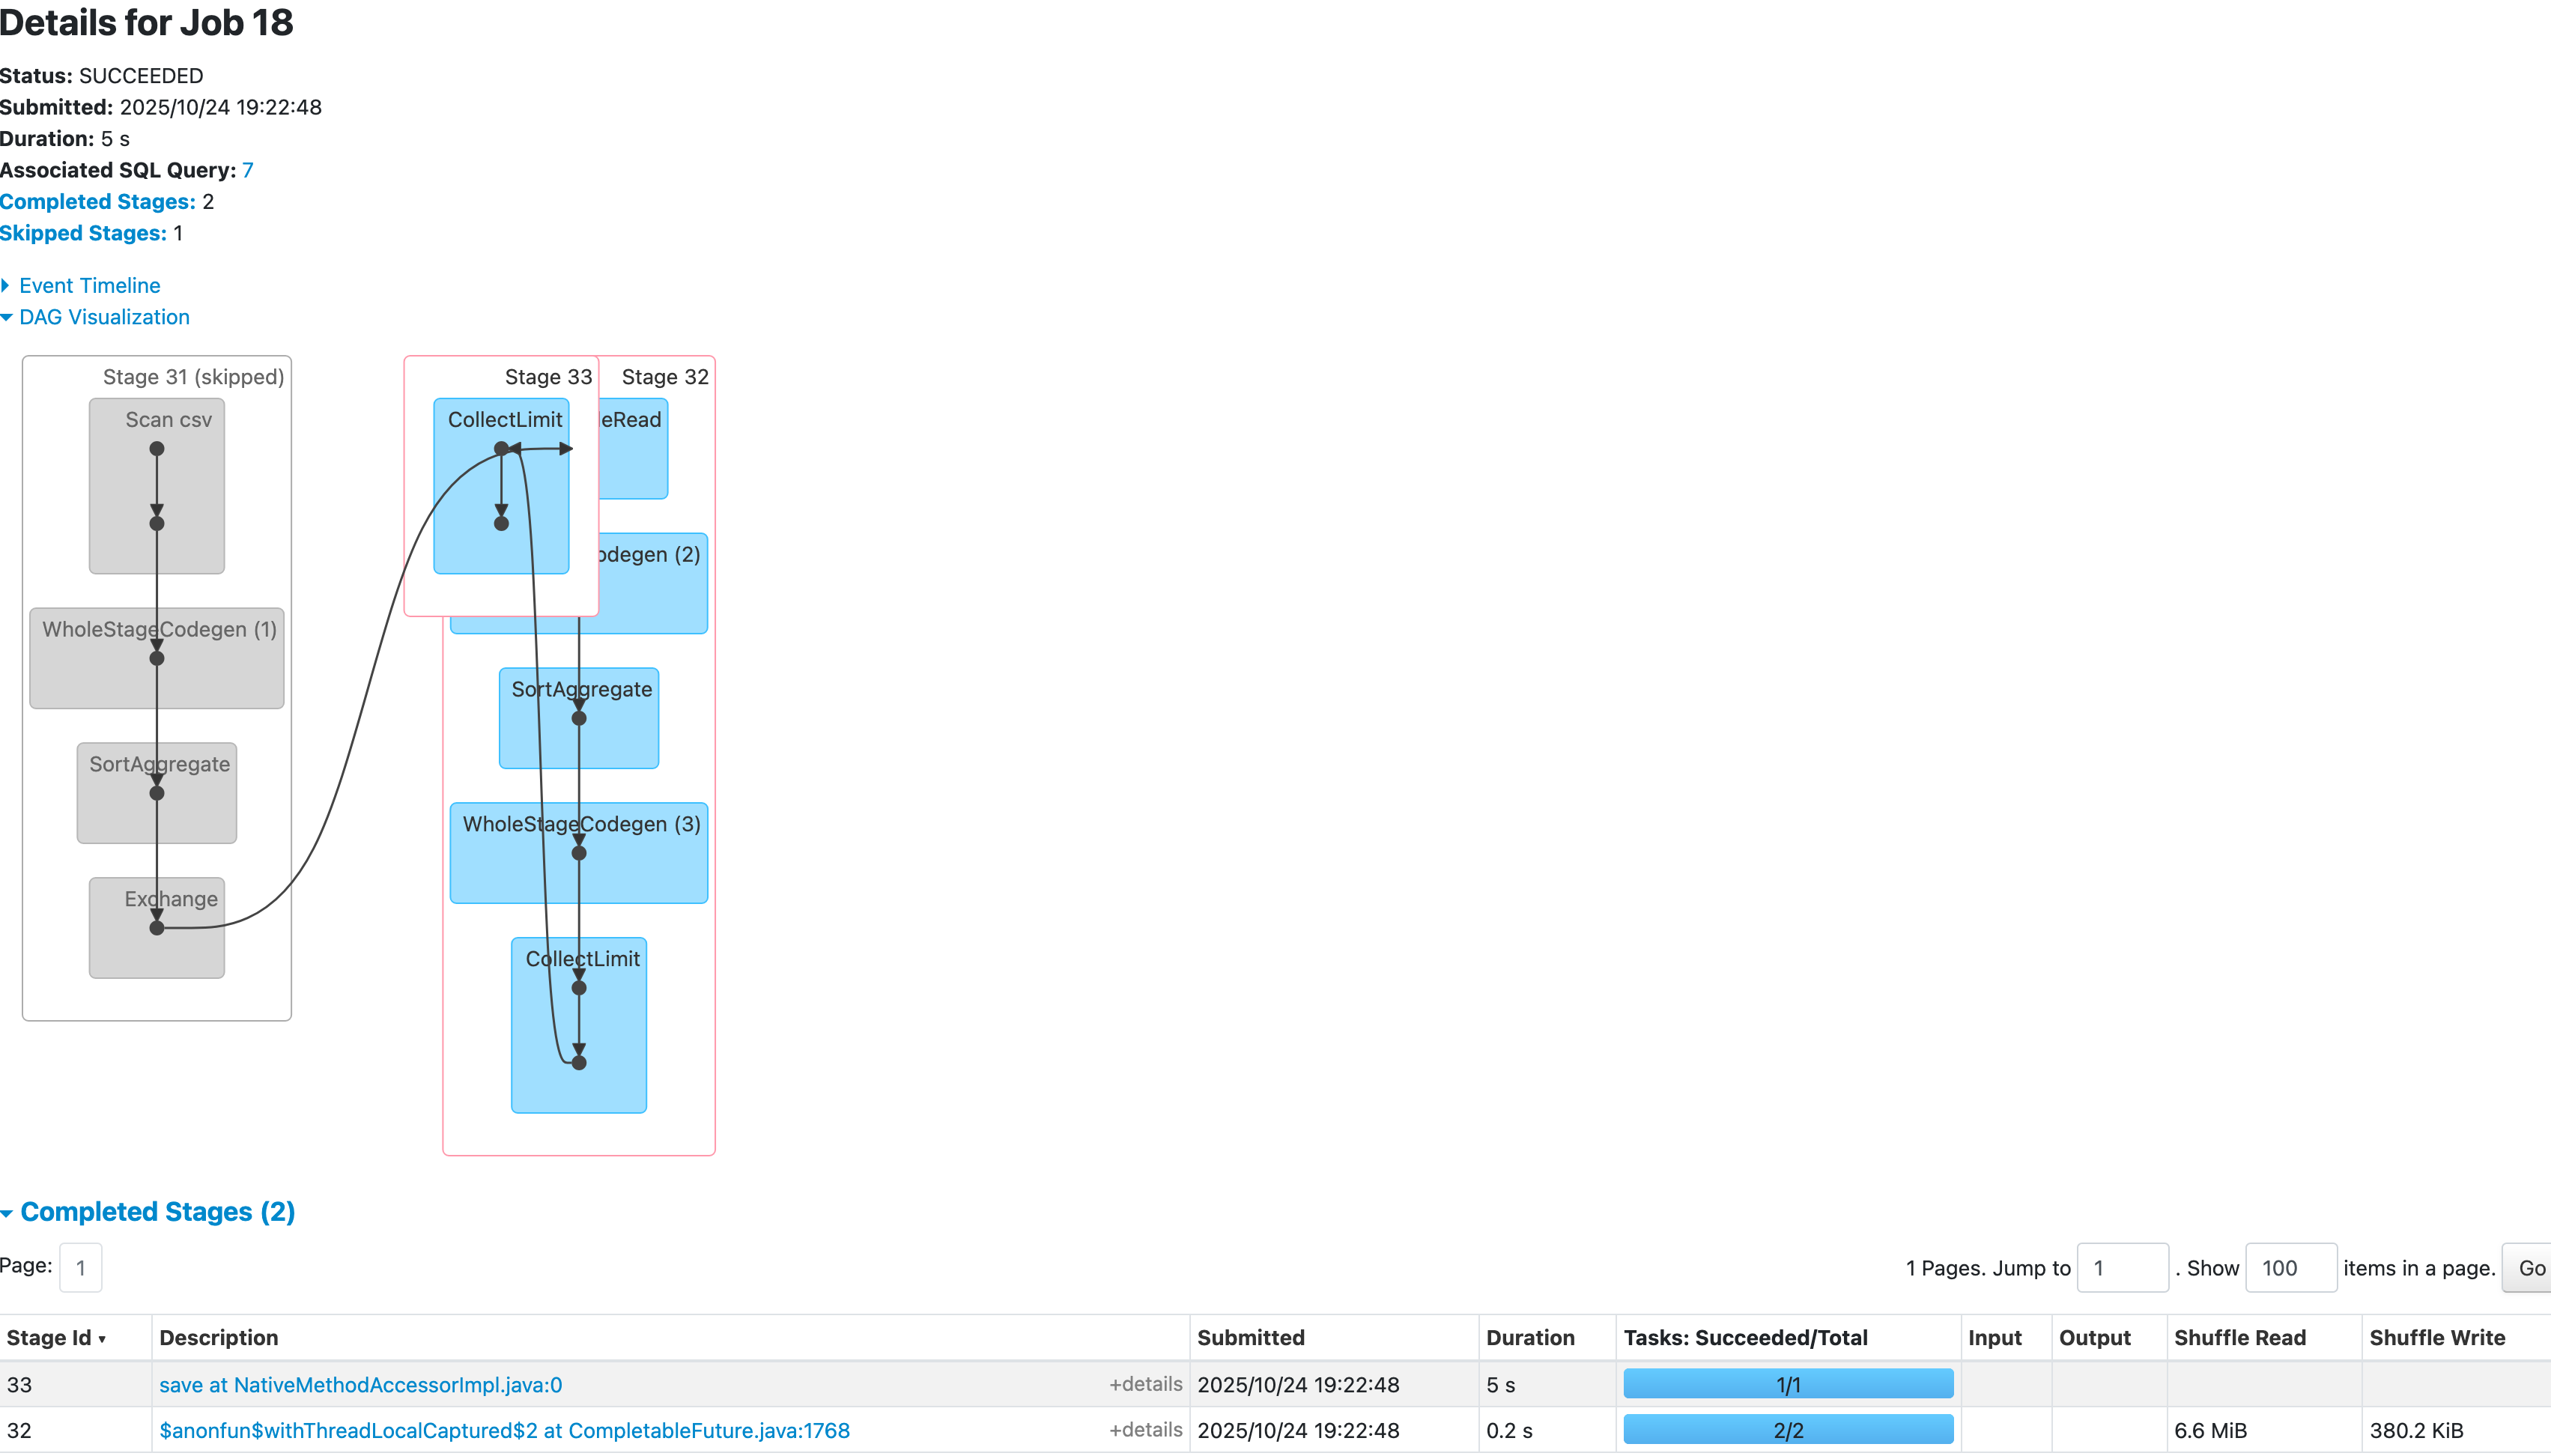

---